In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

In [2]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/jiaqis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- #### Pack the wraggling method above to function, apply to customer data.

In [3]:
def clean_data(df_raw):
    
    df = df_raw.copy()
    # Map categorical value(1A,1B,2A, etc.) to numerical value
    CAMEO_DEU_2015_value = df.groupby(['CAMEO_DEU_2015']).count()['LNR'].index
    CAMEO_DEU_2015_value_map = {}
    for i, item in enumerate(CAMEO_DEU_2015_value):
        # Conside XX as missing value, fill with 0
        if item== 'XX':
            CAMEO_DEU_2015_value_map[item] = 0
        else:
            CAMEO_DEU_2015_value_map[item] = i + 1 
            
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].apply(lambda x: CAMEO_DEU_2015_value_map.get(x))
    df['CAMEO_DEU_2015'].fillna(0, inplace=True)
    
    # Conside X as missing value, fill with 0
    df['CAMEO_DEUG_2015'] = np.where(df['CAMEO_DEUG_2015']=='X', 0, df['CAMEO_DEUG_2015'])
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    df['CAMEO_DEUG_2015'].fillna(0, inplace=True)
    
    # Conside XX as missing value, fill with 0
    df['CAMEO_INTL_2015'] = np.where(df['CAMEO_INTL_2015']=='XX', 0, df['CAMEO_INTL_2015'])
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float')
    df['CAMEO_INTL_2015'].fillna(0, inplace=True)
    
    # Already has encoded columns contain branch info.
    df.drop(['D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)
    
    # Only keep year
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    df['EINGEFUEGT_AM'].fillna(df['EINGEFUEGT_AM'].mode()[0], inplace=True)
    
    # Map O and W to 1 and 2, fill Nan with 0
    df['OST_WEST_KZ'] = np.where(
        df['OST_WEST_KZ']=='O',
        1,
        np.where(df['OST_WEST_KZ']=='W', 2, 0)
    )
    
    kind_col = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
    for col in kind_col:
        df[col] = np.where(df[col]>0, 1, 0)

    df['ALTER_KIND'] = (df['ALTER_KIND1'] + df['ALTER_KIND2']
                            + df['ALTER_KIND3'] + df['ALTER_KIND4'])
    df.drop(kind_col, axis=1, inplace = True)  
    
    df.drop(['EXTSEL992', 'KK_KUNDENTYP'], axis=1, inplace = True)
    
    df.fillna(0, inplace=True)
    
    df_missing = (df.isna().sum()).sum()
    
    print(f'Dataset has {df_missing} missing value.')
    
    return df

In [4]:
azdias_clean = clean_data(azdias)

Dataset has 0 missing value.


In [5]:
customers_clean = clean_data(customers)
customers_clean_nolabel = customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

Dataset has 0 missing value.


In [13]:
azdias_clean['y'] = 0
customers_clean_nolabel['y'] = 1
df = azdias_clean.append(customers_clean_nolabel, ignore_index=True)
X = df[[col for col in df.columns if col not in ['LNR', 'y' ]]]
y = df['y']

In [14]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
ratio_list = []
for i in range(X_norm.shape[1]):
    pca = PCA(n_components=i+1)
    pca.fit(X_norm)
    explained_variance_ratio_sum = pca.explained_variance_ratio_.sum()
    ratio_list.append(explained_variance_ratio_sum)
    #print(f'{i+1} components explains {explained_variance_ratio_sum} of variance.')
    
file = open("pca_explain_variance.plk", "wb")
pickle.dump(ratio_list, file)
file.close()

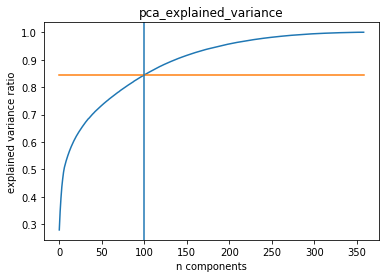

0.8427815209037445

In [55]:
file = open("pca_explain_variance.plk",'rb')
pca_explain_variance = pickle.load(file)
plt.title('pca_explained_variance')
plt.ylabel('explained variance ratio')
plt.xlabel('n components')
plt.plot(pca_explain_variance)
plt.plot(np.full(len(pca_explain_variance), pca_explain_variance[99]))
plt.axvline(x=100)
plt.show()
pca_explain_variance[99]

In [273]:
pca = PCA(n_components=100)
reduced_data = pca.fit_transform(X_norm)

In [ ]:
mss_list = []
for k in range(2,21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_data)
    mss = kmeans.inertia_
    mss_list.append(mss)
    print(f'{k} clusters sum of distances is {mss}.')
    
file = open("kmean_mss.plk", "wb")
pickle.dump(mss_list, file)
file.close()

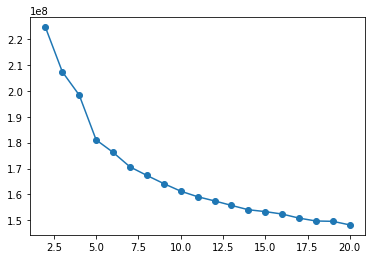

In [78]:
file = open("kmean_mss.plk",'rb')
kmean_mss = pickle.load(file)
plt.plot(range(2,21), kmean_mss, '-o')
plt.show()

In [130]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_5_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [132]:
group_5_result_mean = group_5_result.groupby(['y_group']).mean()

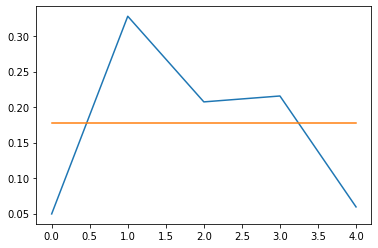

In [133]:
plt.plot(group_5_result_mean)
plt.plot(np.full(len(group_5_result_mean), group_5_result.mean()['y_actual']))
plt.show()

In [134]:
kmeans = KMeans(n_clusters=17)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_17_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [135]:
group_17_result_mean = group_17_result.groupby(['y_group']).mean()

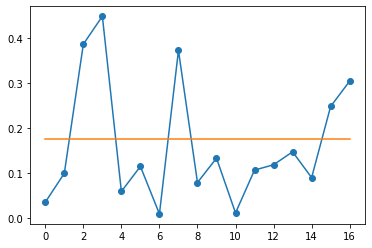

In [139]:
plt.plot(range(17), group_17_result_mean, '-o')
plt.plot(np.full(len(group_17_result_mean), group_17_result.mean()['y_actual']))
plt.show()

 - Target group: 2, 3, 7
 - No Target Group: 0, 6, 10

In [226]:
kmeans.cluster_centers_.shape

(17, 100)

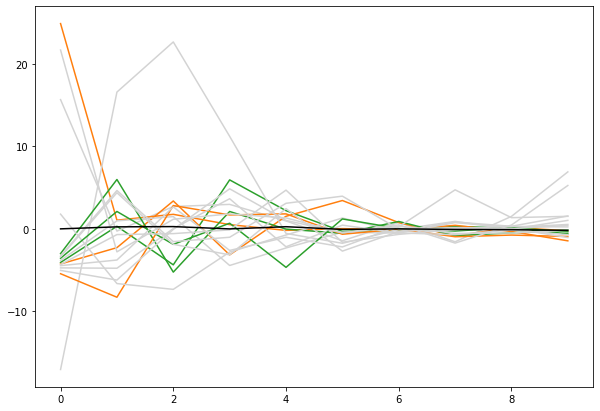

In [259]:
component_number= 10
fig = plt.figure(figsize=(10,7))
for i in range(17):
    if i in [2, 3, 7]:
        color = 'tab:orange'
    elif i in [0, 6, 10]:
        color = 'tab:green'
    else:
        color = 'lightgrey'
    plt.plot(kmeans.cluster_centers_[i, :component_number], color)
    
plt.plot(kmeans.cluster_centers_.mean(axis=1)[:component_number], 'black')

In [291]:
def pca_component_mean_cmpr(group_number, component_number = 20):
    
    group_center = kmeans.cluster_centers_[group_number, :component_number] 
    other_center = ((reduced_data[(y_pred==group_number)&(y==0)].mean(axis=0)[:component_number] - group_center) /
                    pca.explained_variance_ratio_[:component_number])
    target_center = ((reduced_data[(y_pred==group_number)&(y==1)].mean(axis=0)[:component_number] - group_center)/
                     pca.explained_variance_ratio_[:component_number])
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot()
    ax.plot(group_center)
    ax.plot(other_center, 'tab:green')
    ax.plot(target_center,'tab:orange')
    ax.set_xticks(range(component_number))

    return fig

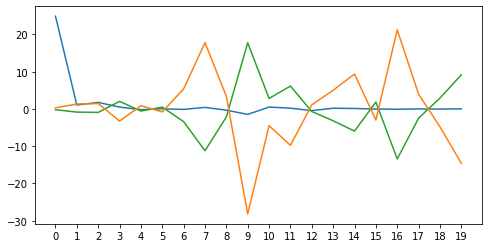

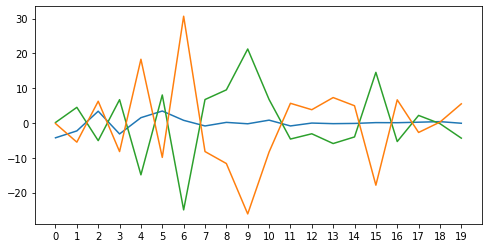

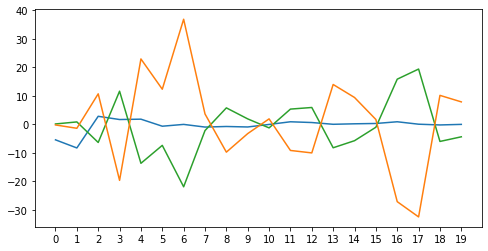

In [292]:
for group_number in [2, 3, 7]:
    pca_component_mean_cmpr(group_number)

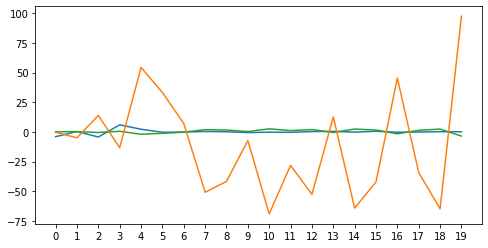

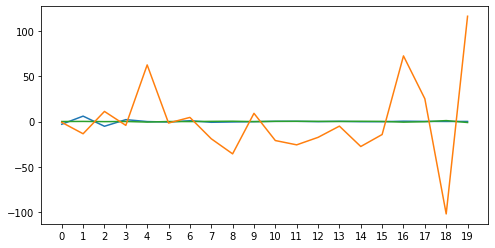

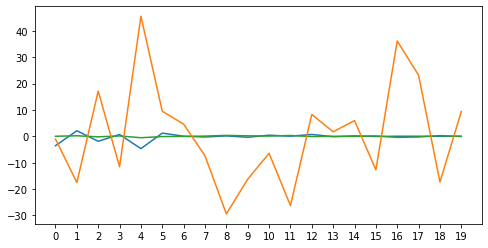

In [293]:
for group_number in [0, 6, 10]:
    pca_component_mean_cmpr(group_number)

In [295]:
component_number = 4
pd.DataFrame({
    'Attribute': [col for col in df.columns if col not in ['LNR', 'y' ]],
    'Loading': abs(pca.components_.T[:, component_number])
}).sort_values(by='Loading', ascending=False).head()

,Attribute,Loading
184,KBA13_ANTG4,0.158649
313,PLZ8_ANTG4,0.154200
183,KBA13_ANTG3,0.143479
188,KBA13_BAUMAX,0.143273
312,PLZ8_ANTG3,0.141145
